In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from fake_useragent import UserAgent
import time
import random
import pymongo
from pymongo import MongoClient
from datetime import datetime
from tomorrow import threads

In [2]:
#變更header使瀏覽器隨機變更
ua = UserAgent()
headers = {"User-Agent":ua.random}

#抓取本機系統時間
def TheTime():
    """抓本機系統時間"""
    ISOTIMEFORMAT = '%Y'
    theTime = datetime.now().strftime(ISOTIMEFORMAT)
    return theTime

#抓取最後一頁
def LastPage(board):
    '''抓最後一頁'''
    res = requests.get("https://www.ptt.cc/bbs/"+str(board)+"/index.html",headers=headers,cookies={'over18': '1'})
    soup = BeautifulSoup(res.text)
    pages = soup.find_all("div",class_="btn-group btn-group-paging")[0].find_all("a",class_="btn wide")[1].get("href").strip("/bbs/"+str(board)+"/index .html")
    return int(pages)+1

#抓取所有文章連結
def GetAllLinks(board,lastpage,stop_page):
    '''抓全部link,輸入的lastpage必須是int'''
    links = []
    while True:
        res = requests.get("https://www.ptt.cc/bbs/"+str(board)+"/index"+str(lastpage)+".html",headers=headers,cookies={'over18': '1'})
        soup = BeautifulSoup(res.text)
        domain = "https://www.ptt.cc/"
        for i in soup.find_all("div",class_="title"):
            try:
                links.append(domain + i.find("a").get("href"))
            except:
                pass
        lastpage -= 1
        if lastpage == int(stop_page):
            break
    return links

#用關鍵字搜尋的去爬文
def GetSearchLinks(board,search,stop_page=10000):
    '''search是要搜尋的關鍵字 '''
    first_page = 1
    links = []
    while True:
        res = requests.get("https://www.ptt.cc/bbs/"+str(board)+"/search?page="+str(first_page)+"&q="+str(search),headers=headers,cookies={'over18': '1'})
        soup = BeautifulSoup(res.text)
        try:
            if soup.find("div",class_="bbs-screen bbs-content").text == '404 - Not Found.':
                break
        except:
            pass
        domain = "https://www.ptt.cc/"
        for i in soup.find_all("div",class_="title"):
            try:
                links.append(domain + i.find("a").get("href"))
            except:
                pass
        first_page += 1
        
        if first_page > int(stop_page):
            break
    return links

#抓取文章相關資訊
def GetPTT(response):
    '''板、url、發文日期、作者、title、內容、回文'''
    soup = BeautifulSoup(response.text)
    Board = soup.find("div",class_="article-metaline-right").find("span",class_="article-meta-value").text
    Url = soup.find("link",rel="canonical").get("href")
    CreateTime = soup.find_all("div",class_="article-metaline")[2].find("span",class_="article-meta-value").text
    CreateTime = datetime.strptime(CreateTime,'%a %b %d %H:%M:%S %Y')
    Author = soup.find_all("div",class_="article-metaline")[0].find("span",class_="article-meta-value").text
    Title = soup.find_all("div",class_="article-metaline")[1].find("span",class_="article-meta-value").text

    content_list = []
    for i in soup.find_all("div",class_="bbs-content")[2].contents[4:]:
        if str(i)[:23] == '<span class="f2">※ 發信站:':
            break
        else:
            try:    
                content_list.append(i.text.replace("\n"," "))
            except:
                content_list.append(i.replace("\n"," "))
    Content = " ".join(content_list)

    Reply = []
    for i in range(len(soup.find_all("div",class_="push"))):
        Reaction  = soup.find_all("div",class_="push")[i].contents[0].text.strip(" ")
        Name = soup.find_all("div",class_="push")[i].contents[1].text.strip(" ")
        Comment = soup.find_all("div",class_="push")[i].contents[2].text.strip(": ")
        Reply_dict = {"Name":Name,"Comment":Comment,"Reaction":Reaction}
        Reply.append(Reply_dict)

    ndf = pd.DataFrame(data = [{
                                "Source":"PTT",
                                "Site":Board,
                                "Url":Url,
                                "CreateTime":CreateTime,
                                "Author":Author,
                                "Title":Title,
                                "Content":Content,
                                "Reply":Reply,
                                "ReplyCount":len(Reply)}],
                       columns = ["Source", "Site", "Url", "CreateTime", "Author", "Title", "Content","Reply","ReplyCount"]) 
    
    return ndf



In [3]:
# 多線程爬蟲定義
@threads(100)
def MultiThread_Crawl(url):
    try:
        res = requests.get(url, headers=headers,cookies={'over18': '1'})
        return res
    except:
        pass

# 爬取連結列表的所有文章    
def CrawlAllNews(links):
    # 爬取全部連結的新聞內容
    print('There are {} links in pages.'.format(len(links)))
    
    # 多線程爬蟲
    responses = [MultiThread_Crawl(link) for link in links]

    # 整理成DataFrame
    allData = []
    for response in responses:
        try:
            ndf = GetPTT(response)
            allData.append(ndf)           
        except:
            pass

    df = pd.concat(allData, ignore_index=True)
    print('There are {} News in DataFrame.'.format(len(df)))
    
    return df

In [4]:
#設定為政黑版的最後一頁
lastpage=LastPage("HatePolitics")
#設定爬取政黑版
links = GetAllLinks(board="HatePolitics",lastpage=lastpage,stop_page=lastpage-20)
#回傳結果為df_result
df_result = CrawlAllNews(links)

There are 384 links in pages.
There are 382 News in DataFrame.


In [5]:
#將reply的內容組成字串，以便做情緒正負向分析
df_result = df_result.fillna('0')
reply_list = []
for y in df_result['Content']:
    each_reply = str()
    if y == '0' or y == "":
        each_reply = '加油!好棒!'
    elif y == '[]':
        each_reply = '加油!好棒!'
#     else:
#         if type(y) == str:
#             y = eval(y.replace("[", "").replace("]", ""))
#             for z in y:
#                 try:
#                     each_reply = each_reply + z['Comment'] 
#                 except TypeError:
#                     pass
#         else:
#             for z in y:
#                 each_reply = each_reply + z['Comment']
    reply_list.append(y.strip()) 

In [6]:
df_result

,Source,Site,Url,CreateTime,Author,Title,Content,Reply,ReplyCount
0,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820297...,2020-02-18 20:42:20,generally (),[討論] 柯粉嗆投廢票選後說投小英騙鬼喔,選前柯粉囂張嗆聲藍綠一樣爛 鼓吹投廢票，還有嗆聲投韓國瑜，更有花蓮柯粉代表表明投韓國瑜 ...,"[{'Name': 'fibula', 'Comment': '沒人在乎你信不信', 'Re...",17
1,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820299...,2020-02-18 20:45:16,clark0816 (罷免烙跑市長韓國瑜),[討論] 罷韓能否過關。要看疫情狀態。,我是高雄市民。我講坦白的。 如同尹立所講的，如果沒有武漢肺炎，15天衝破30萬份。是他們...,"[{'Name': 'MVPGGYY', 'Comment': '韓比較不利的是他自己就是親...",6
2,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820300...,2020-02-18 20:46:50,pp5434 (),[討論] 黃大記者應該懂言論自由吧,我不太懂， 黃大記者，堂堂輔大大傳系的高材生。 怎麼好像不太懂言論自由的樣子。 黃大...,"[{'Name': 'dddcr8024', 'Comment': '爛用的人說人爛用就真的...",1
3,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820301...,2020-02-18 20:49:03,fordmvp (無名氏),[新聞] 【撤僑包機】朱學恆／陸配回台？小心落入,原文網址: 【撤僑包機】朱學恆／陸配回台？小心落入政治陷阱 | 雲論 | ETtoday...,"[{'Name': 'Molester5566', 'Comment': '懶得看 蠢噓豬宅...",4
4,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820301...,2020-02-18 20:49:17,phoenixzero (九尾盛),Re: [討論] 柯粉嗆投廢票選後說投小英騙鬼喔,※ 引述《generally ()》之銘言： : 選前柯粉囂張嗆聲藍綠一樣爛 : 鼓...,"[{'Name': 'spzper', 'Comment': '人家檢討粉絲阿沒問題', '...",7
5,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820303...,2020-02-18 20:52:02,dahanjian (強煎飯),[黑特] 是什麼廢物會說中國官員素質高?,安安 大家好 最近聽到一個震驚小妹我的消息 某直轄市市長和某x海公司的退休高級人物 ...,"[{'Name': 'Molester5566', 'Comment': '慘 要被黨員噓了...",4
6,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820304...,2020-02-18 20:53:20,OusakaMegumu (逢坂恵夢),[新聞]彭博砸錢猛追 引同黨參選人齊轟,彭博砸錢猛追 引同黨參選人齊轟 https://udn.com/news/story/...,"[{'Name': 'MoneyMonkey', 'Comment': '沒辦法，斷頭台和勞...",2
7,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820306...,2020-02-18 20:56:57,fordmvp (無名氏),[討論] 捐中國口罩以外其他醫療物資，大家覺得呢,我倒覺得不必一直要圍繞在口罩話題。 台灣有防疫物資多餘的，如:點滴、針筒。 反正隨便...,"[{'Name': 'Ting5213', 'Comment': '他們只是想罵政府而已',...",2
8,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820308...,2020-02-18 21:00:26,ISAM1 (近藤勇),[黑特] 一天七片哪裡不合理????????????????????,口罩如果日產一千萬 投蔡英文的的八百萬 加她們沒投票的家人起碼一千兩百萬 這些...,"[{'Name': 'proprome', 'Comment': '民眾黨真的是來扯後腿的'...",7
9,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820309...,2020-02-18 21:03:12,biorgan (當賺錢已經是一種習慣時.),[黑特] 到底要不要跟日本新加坡斷航？,小小新加坡已經81例，日本現在奮起直追，很可能馬上除了中國之後的確診數冠軍，我們 怎麼還沒...,[],0


In [7]:
#做情緒正負向分析
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import nltk
import numpy as np
from keras.models import load_model

## 探索數據分析(EDA)
# 計算訓練資料的字句最大字數
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
# 學習情緒正負資料檔
with open('./data/neg_pos2.csv','r+', encoding='UTF-8') as f:
    for line in f:
        label, sentence = line.strip().replace("\ufeff","").split(",")
        words = nltk.word_tokenize(sentence.lower())
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            word_freqs[word] += 1
        num_recs += 1
    print('max_len ',maxlen)
    print('nb_words ', len(word_freqs))

## 準備數據
MAX_FEATURES = 40000
MAX_SENTENCE_LENGTH = 120
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word_index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word_index["PAD"] = 0
word_index["UNK"] = 1
# print(word_index)
index2word = {v:k for k, v in word_index.items()}
X = np.empty(num_recs,dtype=list)
y = np.zeros(num_recs)
i=0
# 讀取訓練資料，將每一單字以 dictionary 儲存
with open('./data/neg_pos2.csv','r+', encoding='UTF-8') as f:
    for line in f:
        label, sentence = line.strip().replace("\ufeff","").split(",")
        words = nltk.word_tokenize(sentence.lower())
        seqs = []
        for word in words:
            if word in word_index:
                seqs.append(word_index[word])
            else:
                seqs.append(word_index["UNK"])
        X[i] = seqs
        y[i] = int(label)
        i += 1

# 字句長度不足補空白        
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)
# 資料劃分訓練組及測試組
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
# 模型構建
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 5
model = Sequential()
# 加『嵌入』層
model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
# 加『LSTM』層
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
# binary_crossentropy:二分法
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

# 模型訓練
model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))

# 預測
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("\nTest score: %.3f, accuracy: %.3f" % (score, acc))
print('{}   {}      {}'.format('預測','真實','句子'))
for i in range(20):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,MAX_SENTENCE_LENGTH)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0] if x != 0])
    print(' {}      {}     {}'.format(int(round(ypred)), int(ylabel), sent))
    
# 模型存檔
model.save('Sentiment1.h5')  # creates a HDF5 file 'model.h5'
    
##### 自己輸入測試
INPUT_SENTENCES = reply_list
XX = np.empty(len(INPUT_SENTENCES),dtype=list)
# 轉換文字為數值
i=0
for sentence in INPUT_SENTENCES:
    words = nltk.word_tokenize(sentence.lower())
    seq = []
    for word in words:
        if word in word_index:
            seq.append(word_index[word])
        else:
            seq.append(word_index['UNK'])
    XX[i] = seq
    i+=1

XX = sequence.pad_sequences(XX, maxlen=MAX_SENTENCE_LENGTH)
# 預測，並將結果四捨五入，轉換為 0 或 1
labels = [int(round(x[0])) for x in model.predict(XX) ]
label2word = {1:'正面', 0:'負面'}
# 顯示結果
emotion = []
for i in range(len(INPUT_SENTENCES)):
#     print('{}   {}'.format(label2word[labels[i]], INPUT_SENTENCES[i]))
    print('{}'.format(label2word[labels[i]]))
#     print('{}'.format(INPUT_SENTENCES[i]))
    print("-------------------------------------")
    emotion.append(label2word[labels[i]])
df_result['Emotion'] = emotion

Using TensorFlow backend.


max_len  409
nb_words  34002


/Users/cafemato/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18094 samples, validate on 4524 samples
Epoch 1/5
18094/18094 [==============================] - 113s 6ms/step - loss: 0.6785 - accuracy: 0.5510 - val_loss: 0.6266 - val_accuracy: 0.6282
Epoch 2/5
18094/18094 [==============================] - 116s 6ms/step - loss: 0.1332 - accuracy: 0.9562 - val_loss: 0.7651 - val_accuracy: 0.6592
Epoch 3/5
18094/18094 [==============================] - 113s 6ms/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.9987 - val_accuracy: 0.6795
Epoch 4/5
18094/18094 [==============================] - 102s 6ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.8579 - val_accuracy: 0.6782
Epoch 5/5
4524/4524 [==============================] - 3s 680us/step

Test score: 1.262, accuracy: 0.681
預測   真實      句子
 1      0     `` '' '' 送了根連接電視的接線，本本上卻沒有的介面，不知為什麼！！！！！！！！ 發貨時我選的圓通快遞，結果是用中通快遞發來的，本本從北京到鄭州的路上跑了兩趟才送到。讓我的等的心急如焚那，收到本本還是蠻興奮的。 '' '' ''
 1      0     `` '' '' 第一次住此類酒店，感覺就是原來的招待所做了一次整潔的裝修。 '' '' ''
 1      1     `` '' '' 正品，包裝沒有開封過。ps：我上次買了個手機，包裝

In [8]:
#關鍵字Jieba訓練
#使用Jieba將文章的Content轉成DataFrame後，取出關鍵字後再存回DataFrame

import jieba
import jieba.analyse
import time
import pymysql

# 設定詞庫
### 繁體字較完整詞庫
jieba.set_dictionary("./dict/dict.txt")

# 載入停用詞詞庫
jieba.analyse.set_stop_words("./dict/stopWords.txt")
    
#要處理的文字內容
Text ='☞☞中原大學風雅頌藝文廳FB粉絲專頁從104年度起，中原大學風雅頌藝文廳在學期中，每週有2場的藝文活動，每回的藝文活動皆會搭配表演者親自講解演出曲目，累積龐大的音樂資料資產，我們將在MOOCs學習影片重現，讓學習者有「身歷其境」之感。「音樂時光隧道」希望帶領大家進入音樂的殿堂，沉浸在美好的音樂時光中，並從中學習到曲式、配器等概念，期望能為所有的音樂學習者設計沒有圍牆、隨時隨地都可以自我學習的音樂教室，如果你喜歡音樂又渴望學習，但苦於沒有機會，那麼這個課程正是一個很好的起點，未來的幾週，請跟著陳文婉老師，一起進入音樂時光隧道'

# 分析關鍵詞
'''
計算TF-IDF分數，並依重要性排列
詞頻(Term Frequency, TF)是指說計算各個分詞在文章中出現的頻率
逆向檔案頻率(Inverse Document Frequency, IDF)是指說計算分詞在各個文章中出現的頻率
TF-IDF即為將TF分數與IDF分數相乘後的值進行比較，若分數越高，則該字詞重要性越大
Jieba 有提供 IDF 的語料庫，也可以透過jieba.analyse中的set_idf_path(file_name)做更改
'''
#單一文章處理範例
jieba.analyse.extract_tags(Text, topK=20, withWeight=True, allowPOS=())

# 全模式
seg_list = jieba.cut(Text, cut_all=True)
print('generator: ',seg_list)
for seg in seg_list:
  print(seg,end=' ')
print('')
seg_list = jieba.lcut(Text, cut_all=True)
print('list: ',seg_list)

# 移除停止詞
def remove_stop_words(file_name,seg_list):
  with open(file_name,'r') as f:
    stop_words = f.readlines()
  stop_words = [stop_word.rstrip() for stop_word in stop_words]
  new_list = []
  
  for seg in seg_list:
    if seg not in stop_words:
      new_list.append(seg)
  return new_list


file_name = './dict/stopWords.txt'
seg_list = remove_stop_words(file_name,seg_list)
print('remove_stop_words: ',seg_list)

# 統計詞頻
def count_segment_freq(seg_list):
  seg_df = pd.DataFrame(seg_list,columns=['seg'])
  seg_df['count'] = 1
  sef_freq = seg_df.groupby('seg')['count'].sum().sort_values(ascending=False)
  sef_freq = pd.DataFrame(sef_freq)
  return sef_freq

#產生文章關鍵字DataFrame
sef_freq = count_segment_freq(seg_list)
#取出前10筆關鍵字
print(sef_freq)
sef_freq = sef_freq[:10]
#轉成Dictionary
sef_freq = sef_freq.to_dict("index")
# sef_freq

Building prefix dict from /Users/cafemato/Desktop/Facebook Crawler/dict/dict.txt ...
Dumping model to file cache /var/folders/jb/3p19_t5x4bzgrry1yznpnlyw0000gn/T/jieba.u100970f52e5eedf7edf77a0c40a82842.cache
Loading model cost 0.832 seconds.
Prefix dict has been built succesfully.


generator:  <generator object Tokenizer.cut at 0x1a4333ac00>
   中原 大學 學風 風雅 風雅頌 藝文 廳 FB 粉絲 專頁 從 104 年度 起   中原 大學 學風 風雅 風雅頌 藝文 廳 在學 學期 期中   每週 有 2 場 的 藝文 活動   每 回 的 藝文 活動 皆 會 搭配 表演 者 親自 講解 演出 曲目   累積 龐大 的 音樂 資料 資產   我們 將 在 MOOCs 學習 影片 重現   讓 學習 者 有   身歷其境   之 感    音樂 時光 隧道   希望 帶領 大家 進入 音樂 的 殿堂   沉浸 在 美好 的 音樂 時光 中   並 從中 中學 學習 學習到 曲式   配器 等 概念   期望 能 為 所有 的 音樂 樂學 學習 者 設計 沒有 圍牆   隨時 隨地 都可 可以 自我 學習 的 音樂 樂教 教室   如果 你 喜歡 音樂 又 渴望 學習   但 苦於 沒有 有機 有機會 機會   那麼 這 個 課程 正 是一 個 很好 的 起點   未來 的 幾 週   請 跟 著 陳 文 婉 老師   一起 進入 音樂 時光 隧道 
list:  ['', '', '', '中原', '大學', '學風', '風雅', '風雅頌', '藝文', '廳', 'FB', '粉絲', '專頁', '從', '104', '年度', '起', '', '', '中原', '大學', '學風', '風雅', '風雅頌', '藝文', '廳', '在學', '學期', '期中', '', '', '每週', '有', '2', '場', '的', '藝文', '活動', '', '', '每', '回', '的', '藝文', '活動', '皆', '會', '搭配', '表演', '者', '親自', '講解', '演出', '曲目', '', '', '累積', '龐大', '的', '音樂', '資料', '資產', '', '', '我們', '將', '在', 'MOOCs', '學習', '影片', '重現', '', '', '讓', '學習', '者', '有', '', '', '身歷其境', '', '', '之', '感', '', '', '', '音樂'

In [29]:
# 關鍵字Jieba分析
count = 0
for index,row in df_result.iterrows():
#     lf = list()
    Text = str(row["Content"])
    Text = Text.replace("\u3000","").replace("\n","").replace(" ","")
    #取出Content關鍵字
    jieba.analyse.extract_tags(Text, topK=10, withWeight=False, allowPOS=())
    #全模式分詞，使用cut回傳值為可叠代的generator，可以使用 for 循環來獲得分詞後得到的每一個詞語

    #精確模式，使用lcut回傳值為list
    seg_list = jieba.lcut(Text, cut_all=False)
#     print('list: ',seg_list)
    
    #給予停止詞檔案路徑，並移除文章內的停止詞
    file_name = './dict/stopWords.txt'
    seg_list = remove_stop_words(file_name,seg_list)
#     print('remove_stop_words: ',seg_list)
    
    #計算詞頻，以每篇文章排名前10名的作為關鍵字
    sef_freq = count_segment_freq(seg_list)
    sef_freq = sef_freq[:10]
    #轉成Dictionary並轉成字串格式    
    sef_freq = str(sef_freq.to_dict("index"))
    #附加回原本的DataFrame
    df_result.loc[index,'AutoKey'] = sef_freq
#     print(count)
    count = count + 1


In [10]:
df_result

,Source,Site,Url,CreateTime,Author,Title,Content,Reply,ReplyCount,Emotion,AutoKey
0,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820297...,2020-02-18 20:42:20,generally (),[討論] 柯粉嗆投廢票選後說投小英騙鬼喔,選前柯粉囂張嗆聲藍綠一樣爛 鼓吹投廢票，還有嗆聲投韓國瑜，更有花蓮柯粉代表表明投韓國瑜 ...,"[{'Name': 'fibula', 'Comment': '沒人在乎你信不信', 'Re...",17,負面,"{'柯粉': {'count': 8}, '投': {'count': 6}, '嗆聲': ..."
1,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820299...,2020-02-18 20:45:16,clark0816 (罷免烙跑市長韓國瑜),[討論] 罷韓能否過關。要看疫情狀態。,我是高雄市民。我講坦白的。 如同尹立所講的，如果沒有武漢肺炎，15天衝破30萬份。是他們...,"[{'Name': 'MVPGGYY', 'Comment': '韓比較不利的是他自己就是親...",6,正面,"{'韓國': {'count': 7}, '瑜': {'count': 7}, '瘟疫': ..."
2,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820300...,2020-02-18 20:46:50,pp5434 (),[討論] 黃大記者應該懂言論自由吧,我不太懂， 黃大記者，堂堂輔大大傳系的高材生。 怎麼好像不太懂言論自由的樣子。 黃大...,"[{'Name': 'dddcr8024', 'Comment': '爛用的人說人爛用就真的...",1,負面,"{'自由': {'count': 9}, '言論': {'count': 7}, '說': ..."
3,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820301...,2020-02-18 20:49:03,fordmvp (無名氏),[新聞] 【撤僑包機】朱學恆／陸配回台？小心落入,原文網址: 【撤僑包機】朱學恆／陸配回台？小心落入政治陷阱 | 雲論 | ETtoday...,"[{'Name': 'Molester5566', 'Comment': '懶得看 蠢噓豬宅...",4,負面,"{'撤僑': {'count': 18}, '北京': {'count': 15}, '武漢..."
4,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820301...,2020-02-18 20:49:17,phoenixzero (九尾盛),Re: [討論] 柯粉嗆投廢票選後說投小英騙鬼喔,※ 引述《generally ()》之銘言： : 選前柯粉囂張嗆聲藍綠一樣爛 : 鼓...,"[{'Name': 'spzper', 'Comment': '人家檢討粉絲阿沒問題', '...",7,負面,"{'投': {'count': 10}, '柯粉': {'count': 8}, 'gene..."
5,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820303...,2020-02-18 20:52:02,dahanjian (強煎飯),[黑特] 是什麼廢物會說中國官員素質高?,安安 大家好 最近聽到一個震驚小妹我的消息 某直轄市市長和某x海公司的退休高級人物 ...,"[{'Name': 'Molester5566', 'Comment': '慘 要被黨員噓了...",4,正面,"{'中國': {'count': 3}, 'x': {'count': 2}, '素質': ..."
6,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820304...,2020-02-18 20:53:20,OusakaMegumu (逢坂恵夢),[新聞]彭博砸錢猛追 引同黨參選人齊轟,彭博砸錢猛追 引同黨參選人齊轟 https://udn.com/news/story/...,"[{'Name': 'MoneyMonkey', 'Comment': '沒辦法，斷頭台和勞...",2,負面,"{'彭博': {'count': 10}, '說': {'count': 7}, ',': ..."
7,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820306...,2020-02-18 20:56:57,fordmvp (無名氏),[討論] 捐中國口罩以外其他醫療物資，大家覺得呢,我倒覺得不必一直要圍繞在口罩話題。 台灣有防疫物資多餘的，如:點滴、針筒。 反正隨便...,"[{'Name': 'Ting5213', 'Comment': '他們只是想罵政府而已',...",2,負面,"{'送': {'count': 3}, '中國': {'count': 3}, '幫助': ..."
8,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820308...,2020-02-18 21:00:26,ISAM1 (近藤勇),[黑特] 一天七片哪裡不合理????????????????????,口罩如果日產一千萬 投蔡英文的的八百萬 加她們沒投票的家人起碼一千兩百萬 這些...,"[{'Name': 'proprome', 'Comment': '民眾黨真的是來扯後腿的'...",7,正面,"{'相信': {'count': 3}, '黨': {'count': 2}, '買': {..."
9,PTT,HatePolitics,https://www.ptt.cc/bbs/HatePolitics/M.15820309...,2020-02-18 21:03:12,biorgan (當賺錢已經是一種習慣時.),[黑特] 到底要不要跟日本新加坡斷航？,小小新加坡已經81例，日本現在奮起直追，很可能馬上除了中國之後的確診數冠軍，我們 怎麼還沒...,[],0,負面,"{'馬上': {'count': 1}, '飛過去': {'count': 1}, '817..."


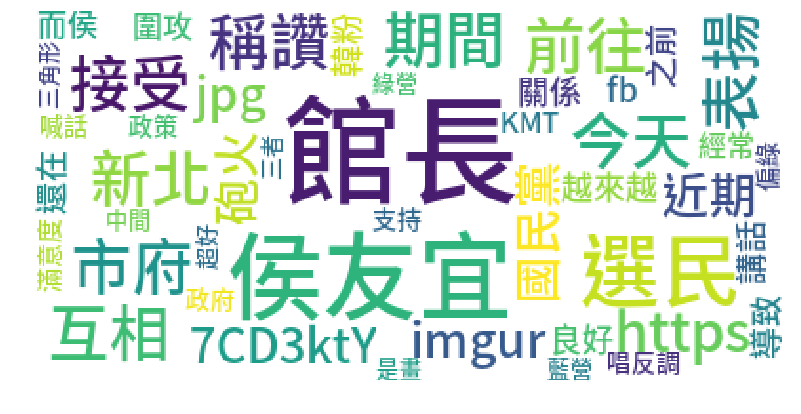

In [30]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

font_path = './NotoSansCJKtc-Medium.OTF' # 標楷體
seg_list=' '.join(seg_list)

wc = WordCloud(background_color='white',font_path=font_path)
wc.generate(seg_list)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,7))
plt.imshow(wc)
plt.axis("off")
plt.show()